In [1]:
# import library yang diperlukan
import pandas as pd
import numpy as np
from datetime import *
from netCDF4 import Dataset
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

 File '2010.nc' berisi data rata-rata suhu di beberapa titik koordinat di Asia pada sepanjang tahun 2010.

Akan diprediksi suhu rata-rata di Jakarta pada 30 hari ke depan, setelah akhir tahun 2010 menggunakan FBProphet.
Posisi Jakarta adalah di lat: -6.125, long: 106.875

In [2]:
# membaca isi file
data = Dataset('2010.nc')

In [3]:
# menampilkan isi variabel dari dataset
data.variables.keys()

dict_keys(['lon', 'lat', 'time', 'tave', 'rstn'])

In [4]:
# ambil semua data latitude
lat = data.variables['lat'][:]
print(lat[:5])

[-14.875 -14.625 -14.375 -14.125 -13.875]


In [5]:
# mengetahui index posisi latitude=-6.125 (Jakarta) di data latitude
np.where(lat == -6.125)

# index posisi lat ini nanti akan digunakan untuk mendapatkan data suhu di Jakarta

(array([35], dtype=int64),)

ditemukan index posisi latitude Jakarta ada di index ke-35

In [6]:
# ambil semua data longitude
long = data.variables['lon'][:]
print(long[:5])

[60.125 60.375 60.625 60.875 61.125]


In [7]:
# mengetahui index posisi longitude 106.875 (Jakarta) di dalam data longitude
np.where(long == 106.875)

(array([187], dtype=int64),)

diperoleh index posisi longitude Jakarta ada di index ke-187

In [8]:
# ambil semua data time
time = data.variables['time'][:]
print(time[:5])

[   0. 1440. 2880. 4320. 5760.]


data time di atas dalam satuan menit, dihitung mulai dari tanggal 1/1/2010. Sehingga untuk memudahkan analisis perlu dikonversi ke format date terlebih dahulu.<br><br>
Misal:<br>
0 menit -> tanggal 1/1/2010<br>
1440 menit -> tanggal 2/1/2010 (1440 menit atau 24 jam atau 1 hari setelah tanggal 1/1/2010)<br>
2880 menit -> tanggal 3/1/2010 (2880 menit atau 48 jam atau 2 hari setelah tanggal 1/1/2010)<br>
dan seterusnya..

In [9]:
# membuat list tanggal dari data time, terhitung mulai tanggal 1/1/2010
dataTime = list(map(lambda x: str(date(2010,1,1) + timedelta(hours=x/60)), time))

In [10]:
# tampilan list tanggal (hanya 5 yang pertama sj yang ditampilkan)
dataTime[:5]

['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05']

In [11]:
# ambil semua data rata-rata suhu
tave = data.variables['tave'][:]

In [12]:
# ambil data rata-rata suhu di Jakarta berdasarkan index posisi latitude dan longitude
temp = tave[:, 35, 187]

In [13]:
# membuat dictionary berisi data time dan data rata-rata suhu di Jakarta
myData = {'time': dataTime, 'temp': temp}

In [14]:
# mengkonversi dictionary ke dataframe
data = pd.DataFrame(myData, columns = ['time','temp'])

In [15]:
# FBProphet mewajibkan penamaan kolom waktunya dengan 'ds', dan kolom nilainya dengan 'y'
# mengubah nama kolom 'time' ke 'ds' dan 'temp' ke 'y'
data = data.rename(columns={'time': 'ds', 'temp': 'y'})

In [16]:
data.head()

,ds,y
0,2010-01-01,28.567158
1,2010-01-02,28.054541
2,2010-01-03,28.693995
3,2010-01-04,29.311541
4,2010-01-05,28.096054


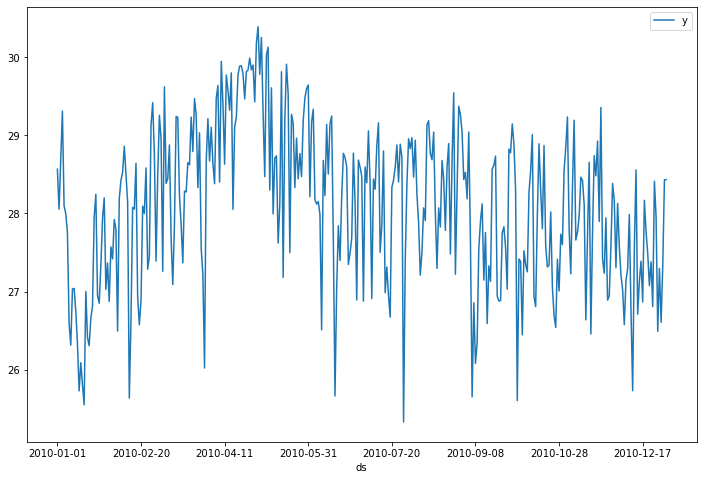

In [17]:
# mengeset kolom 'ds' dari dataset sebagai index lalu memplotnya
ax = data.set_index('ds').plot(figsize=(12, 8))

In [18]:
# setting konfigurasi fbprophet pada level konfidensi 95%
# menggunakan analisis seasonality harian, mingguan, bulanan, tahunan
my_model = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
my_model.add_seasonality(name='monthly', period=30.5, fourier_order=3)

In [19]:
# membuat model
my_model.fit(data)

In [20]:
# membuat deret tanggal untuk 30 hari ke depan (setelah tanggal terakhir di dataset)
future_dates = my_model.make_future_dataframe(periods=30)
future_dates.head()

,ds
0,2010-01-01
1,2010-01-02
2,2010-01-03
3,2010-01-04
4,2010-01-05


In [21]:
# memprediksi suhu rata-rata Jakarta 30 hari ke depan
# yhat_lower dan yhat_upper adalah batas bawah dan atas nilai prediksi
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-01,28.884613,27.506624,30.377125
1,2010-01-02,28.571067,27.105740,29.934424
2,2010-01-03,28.196790,26.776013,29.603171
3,2010-01-04,27.937382,26.451897,29.385683
4,2010-01-05,27.481465,26.064459,28.860330
...,...,...,...,...
390,2011-01-26,25.107054,23.697285,26.453701
391,2011-01-27,25.344057,23.862903,26.703306
392,2011-01-28,25.629057,24.103192,27.001515
393,2011-01-29,25.966531,24.558798,27.436609


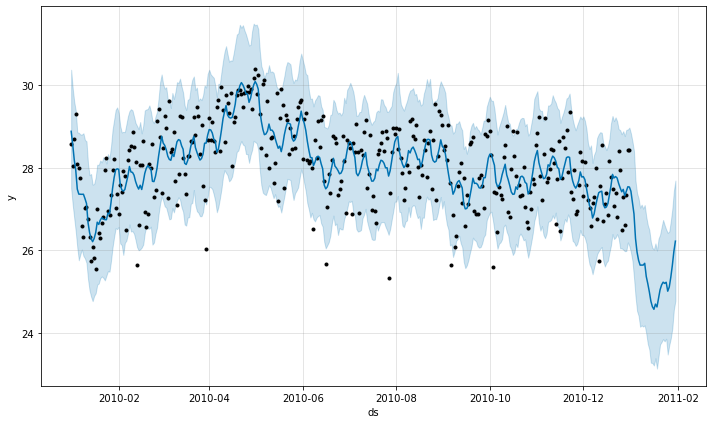

In [22]:
# memplot titik data asli, dan hasil prediksi
my_model.plot(forecast, uncertainty=True);

Keterangan:<br>
* Titik-titik hitam menunjukkan data real dari dataset
* Garis biru tua menunjukkan nilai prediksi
* Shade warna biru muda menunjukkan range toleransi prediksi (batas bawah, batas atas)

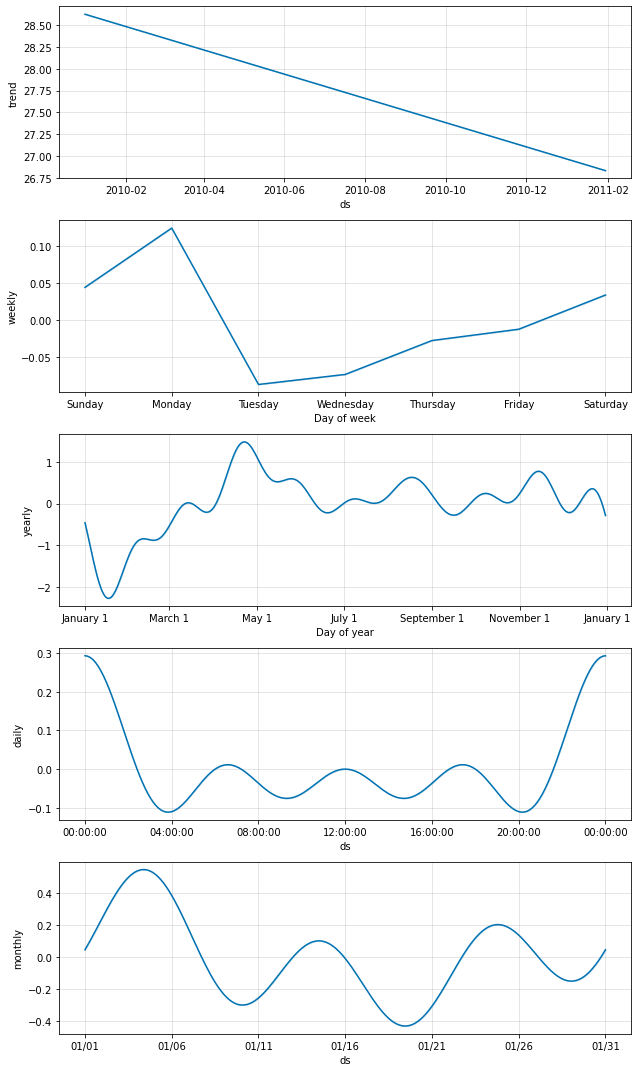

In [23]:
# memplot trend data dari keseluruhan data, serta seasonality: harian, mingguan, bulanan, dan tahunan
my_model.plot_components(forecast);